In [1]:
# Import libraries
from google.colab import files
import zipfile
import io

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
from torch.utils.data import Subset

In [2]:
# Upload zip file of all the Etsy images
uploaded = files.upload()

Saving EtsyImages.zip to EtsyImages.zip


In [3]:
# Unzip files
zf = zipfile.ZipFile(io.BytesIO(uploaded['EtsyImages.zip']), "r")
zf.extractall()

In [4]:
data_dir = "/content/Etsy"
train_ratio = 0.7
batch_size = 10

In [5]:
# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop([150, 150]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([500, 500]),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

transform_test = transforms.Compose([
    transforms.CenterCrop([150, 150]),
    transforms.Resize([500, 500]),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Apply data augmentation on the images
full_dataset_train_tf = datasets.ImageFolder(root=data_dir, transform=transform_train)
full_dataset_test_tf  = datasets.ImageFolder(root=data_dir, transform=transform_test)

In [6]:
# Split the data inot train and test
dataset_size = len(full_dataset_train_tf)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

torch.manual_seed(1) # Set the seed
train_dataset, test_dataset = random_split(full_dataset_train_tf, [train_size, test_size])

test_dataset = random_split(full_dataset_test_tf, [train_size, test_size])[1]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [8]:
# Subset the data
train_subset_size = 20
test_subset_size  = 10

# Ensure we don't exceed dataset size
train_subset_size = min(train_subset_size, len(train_dataset))
test_subset_size  = min(test_subset_size, len(test_dataset))

# Create subsets
etsy_train_dataset = Subset(train_dataset, torch.arange(train_subset_size))
etsy_test_dataset  = Subset(test_dataset,  torch.arange(test_subset_size))

# Print subset sizes
print("Train subset:", len(etsy_train_dataset))
print("Test subset :", len(etsy_test_dataset))


Train subset: 20
Test subset : 10


In [9]:
# Load in the data
batch_size = 10
torch.manual_seed(1)
train_dl = DataLoader(etsy_train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(etsy_test_dataset, batch_size, shuffle=False)

In [10]:
# Set up the model architecture
model = nn.Sequential()

# Block 1
model.add_module('conv1', nn.Conv2d(3, 32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('dropout1', nn.Dropout(0.3))

# Block 2
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('dropout2', nn.Dropout(0.4))   # controlled dropout

# Block 3
model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(2))

# Block 4
model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

model.add_module('gap', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())


In [11]:
# Choose loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [12]:
def train(model, num_epochs, train_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()  # enable training mode

        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss: {loss_hist_train[epoch]:.4f}, "
              f"Accuracy: {accuracy_hist_train[epoch]:.4f}")

    return loss_hist_train, accuracy_hist_train

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# Train the model
torch.manual_seed(1) # Set seed
num_epochs = 8
loss_hist, acc_hist = train(model, num_epochs, train_loader)


Epoch 1/8 - Loss: 0.6868, Accuracy: 0.6250
Epoch 2/8 - Loss: 0.6840, Accuracy: 0.6250
Epoch 3/8 - Loss: 0.6801, Accuracy: 0.6250
Epoch 4/8 - Loss: 0.6806, Accuracy: 0.6250
Epoch 5/8 - Loss: 0.6759, Accuracy: 0.6250
Epoch 6/8 - Loss: 0.6748, Accuracy: 0.6250
Epoch 7/8 - Loss: 0.6721, Accuracy: 0.6250
Epoch 8/8 - Loss: 0.6732, Accuracy: 0.6250


Epoch 1/8 - Loss: 0.7067, Accuracy: 0.5000
Epoch 2/8 - Loss: 0.7046, Accuracy: 0.5000
Epoch 3/8 - Loss: 0.7091, Accuracy: 0.5000
Epoch 4/8 - Loss: 0.7087, Accuracy: 0.5000
Epoch 5/8 - Loss: 0.7064, Accuracy: 0.5000
Epoch 6/8 - Loss: 0.7024, Accuracy: 0.5000
Epoch 7/8 - Loss: 0.7014, Accuracy: 0.5000
Epoch 8/8 - Loss: 0.7059, Accuracy: 0.5000


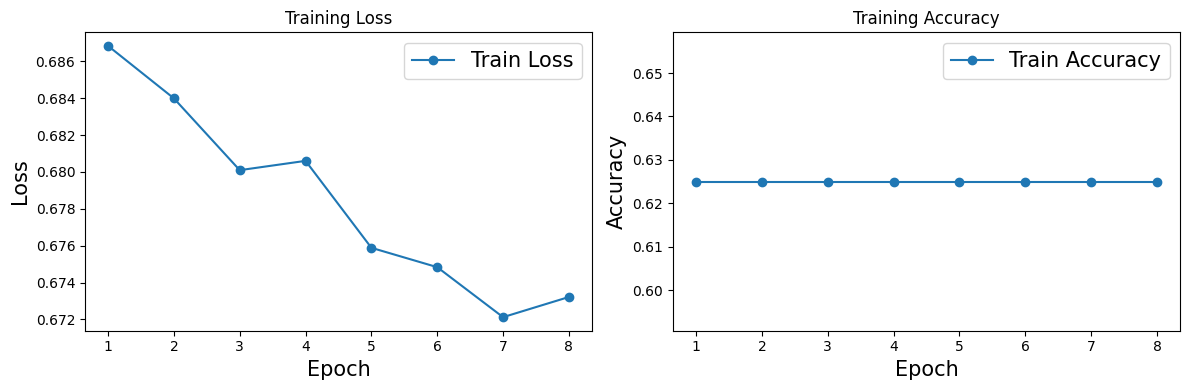

In [15]:
# Plot the training loss and accuracy
#hist = train(model, num_epochs, train_dl)

epochs = np.arange(len(loss_hist)) + 1
fig = plt.figure(figsize=(12, 4))

# Loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs, loss_hist, '-o', label='Train Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_title("Training Loss")

# Accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs, acc_hist, '-o', label='Train Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_title("Training Accuracy")

plt.tight_layout()
plt.show()


In [16]:
# Use the model on the test set
# Find the accuracy
accuracy_test = 0

model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.7000
